# Custom Datasets

### [Resource](https://www.learnpytorch.io/04_pytorch_custom_datasets/)

We've used some datasets with PyTorch before. But how do you get your own data into PyTorch?

One of the ways to do so is via: **custom datasets**.

## Domain Libraries

Depending on what you're working on vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

In that case, we can always subclass [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and customize it to our liking.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png">


| Problem Space   | Pre-built Datasets and Functions|             
|-----------------|-----------------------------|
| Vision                 | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html)|
| Audio                  | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html)|
| Text                   | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html)|
| Recommendation System  | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html)|



## Content to Cover in Computer Vision

We're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png">

| Topic                                     | Contents                                                                                     |
|-------------------------------------------|----------------------------------------------------------------------------------------------|
| 0. Importing PyTorch and setting up device-agnostic code   | Let's get PyTorch loaded and set up code to be device-agnostic.                               |
| 1. Get data                               | Use a **custom dataset** of pizza, steak, and sushi images.                                        |
| 2. Become one with the data(data preparation)         | Understand the dataset at the beginning of a machine learning problem.                         |
| 3. Transforming data                      | Prepare data for machine learning models.                                                     |
| 4. Loading data with ImageFolder (option 1)| Use PyTorch's ImageFolder for standard image classification format.                            |
| 5. Loading image data with a custom Dataset | Build a custom subclass of [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for non-standard data.                    |
| 6.  Other forms of transforms (data augmentation) | Explore torchvision's in-built data augmentation functions.                                   |
| 7. Model 0: TinyVGG without data augmentation | Build and train a model without data augmentation.                                            |
| 8. Exploring loss curves                   | Analyze loss curves to evaluate model training and performance.                                |
| 9. Model 1: TinyVGG with data augmentation | Build and train a model with data augmentation.                                               |
| 10. Compare model results                 | Compare loss curves and discuss performance improvement options.                              |
| 11. Making a prediction on a custom image | Use the trained model to predict on an image outside the dataset.                               |


## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


## 1. Get Data
We're commencing with a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a renowned computer vision benchmark comprising 101,000 images of 101 distinct foods. To simplify, we're narrowing our focus to three delectable classes: pizza, steak, and sushi. Instead of 1,000 images per class, we're starting with a random 30% (begin modestly, scale up as needed).

*Refer to the [Extras/Pytorch_Custom_Food_Datasets.ipynb](https://github.com/LuluW8071/Data-Science/tree/main/Pytorch/04_PyTorch_Custom_Datasets/Extras/Pytorch_Custom_Food_Datasets.ipynb) notebook for creating a subset of the Food101 dataset*.

[*Download the prepared custom dataset here separately*](https://github.com/LuluW8071/Data-Science/tree/main/Pytorch/04_PyTorch_Custom_Datasets/Extras)

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/LuluW8071/Data-Science/raw/main/Pytorch/04_PyTorch_Custom_Datasets/Extras/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Did not find data directory, creating one...
Unzipping pizza, steak, sushi data...


## 2. Become one with the data(data preparation)
<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-abraham-lossfunction.png">

The storage format below, the images numbers are arbitrary.
```
data/pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

The goal will be to take this **data storage structure and turn it into a dataset usable with PyTorch**.

In [3]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 1 directories and 1 images in 'data'.
There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 84 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 71 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 70 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 226 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 228 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 221 images in 'data/pizza_steak_sushi/train/pizza'.


In [4]:
# Setup train and test paths
train_dir = image_path / 'pizza_steak_sushi/train'
test_dir = image_path / 'pizza_steak_sushi/test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing Image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's [PIL](https://pypi.org/project/pillow/)
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/sushi/1423517.jpg
Image Class: sushi
Image Height: 384
Image Width: 512


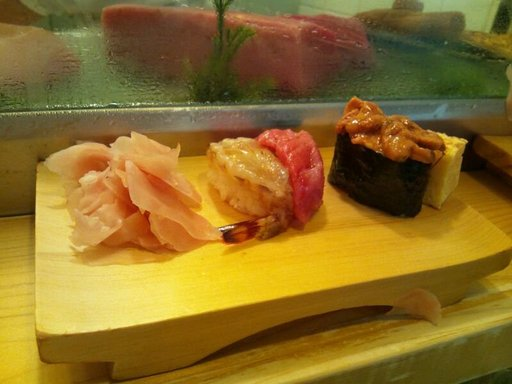

In [5]:
import random
from PIL import Image

# random.seed(42)

# 1. Get all of the image paths
image_path = data_path / "pizza_steak_sushi"
image_path_list = list(image_path.glob("*/*/*.jpg"))  # *(data)/*(pizza_steak_sushi)/*(testORtrain)/.jpg

# 2. Pick a random image path using Python's random.choice()
random_image_path = random.choice(image_path_list)
# print(random_image_path)

# 3. Get the image class from path name
# the image class is the name of the directory where
image_class = random_image_path.parent.stem
# print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

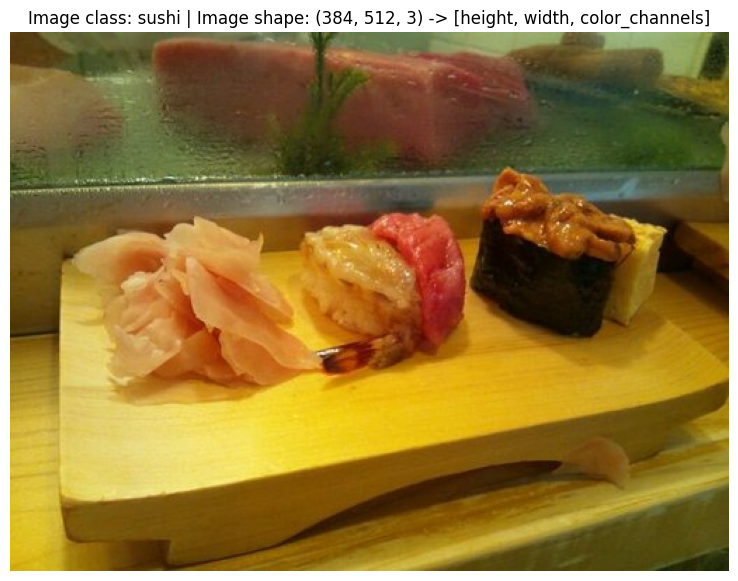

In [6]:
# Visualizing using matplotliib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
fig = plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)
plt.show()

array([[[ 98,  72,  23],
        [ 96,  70,  21],
        [ 93,  66,  19],
        ...,
        [ 56,  68,  20],
        [ 58,  70,  22],
        [ 65,  77,  29]],

       [[ 92,  65,  18],
        [ 91,  64,  17],
        [ 89,  62,  15],
        ...,
        [ 58,  70,  22],
        [ 60,  72,  24],
        [ 65,  77,  29]],

       [[ 87,  60,  15],
        [ 87,  60,  15],
        [ 86,  59,  14],
        ...,
        [ 61,  73,  27],
        [ 62,  74,  28],
        [ 65,  77,  31]],

       ...,

       [[209, 173,  15],
        [206, 170,  12],
        [205, 169,  11],
        ...,
        [ 34,  44,   9],
        [ 34,  44,   9],
        [ 33,  43,   8]],

       [[206, 170,  12],
        [205, 169,  11],
        [208, 172,  14],
        ...,
        [ 34,  44,   7],
        [ 35,  45,   8],
        [ 34,  44,   7]],

       [[202, 166,   8],
        [204, 168,  10],
        [210, 174,  16],
        ...,
        [ 35,  45,   8],
        [ 36,  46,   9],
        [ 36,  46,   9]]], dtype=uint8)
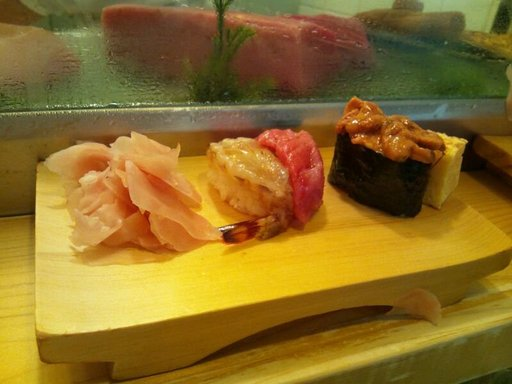

In [7]:
img_as_array

## 3. Transforming data
Before we can use our image data with PyTorch
1. Turn your target data into tensors (in our case, numerical representation of our images.)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

### 3.1 Transforming data with [`torchvision.transforms`](https://pytorch.org/vision/0.9/transforms.html)

Transforms help you get your images ready toi be used with a model/perform data augmentation.

In [8]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

print(torchvision.__version__)

0.16.0+cu121


In [9]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 224x224
    transforms.Resize(size = (224, 224)),
    # Flip the images randomly on the horizontally
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn image into Tensor
    transforms.ToTensor()
])

In [10]:
transformed_data = data_transform(img)

transformed_data, transformed_data.shape, transformed_data.dtype

(tensor([[[0.2392, 0.2392, 0.2667,  ..., 0.3373, 0.3569, 0.3686],
          [0.2471, 0.2431, 0.2549,  ..., 0.3373, 0.3373, 0.3412],
          [0.2431, 0.2314, 0.2314,  ..., 0.3294, 0.3294, 0.3373],
          ...,
          [0.1333, 0.1216, 0.1176,  ..., 0.8157, 0.8157, 0.8275],
          [0.1333, 0.1216, 0.1098,  ..., 0.8196, 0.8078, 0.8118],
          [0.1373, 0.1255, 0.1059,  ..., 0.8314, 0.8314, 0.8039]],
 
         [[0.2863, 0.2863, 0.3098,  ..., 0.2431, 0.2510, 0.2627],
          [0.2941, 0.2902, 0.2980,  ..., 0.2353, 0.2314, 0.2353],
          [0.2902, 0.2784, 0.2745,  ..., 0.2235, 0.2235, 0.2314],
          ...,
          [0.1686, 0.1608, 0.1569,  ..., 0.6745, 0.6745, 0.6863],
          [0.1725, 0.1608, 0.1490,  ..., 0.6784, 0.6667, 0.6706],
          [0.1765, 0.1647, 0.1451,  ..., 0.6902, 0.6902, 0.6627]],
 
         [[0.0980, 0.1020, 0.1373,  ..., 0.0667, 0.0706, 0.0745],
          [0.1098, 0.1137, 0.1294,  ..., 0.0588, 0.0549, 0.0588],
          [0.1176, 0.1059, 0.1176,  ...,

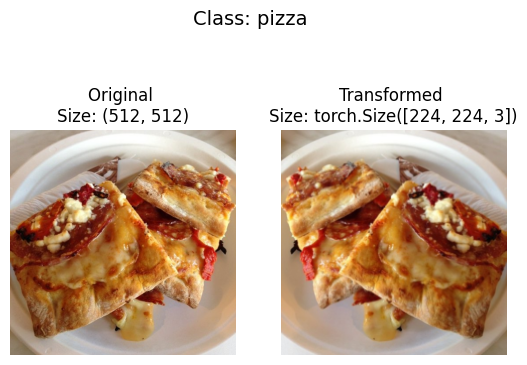

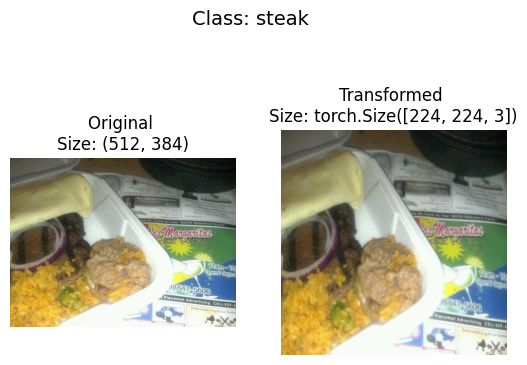

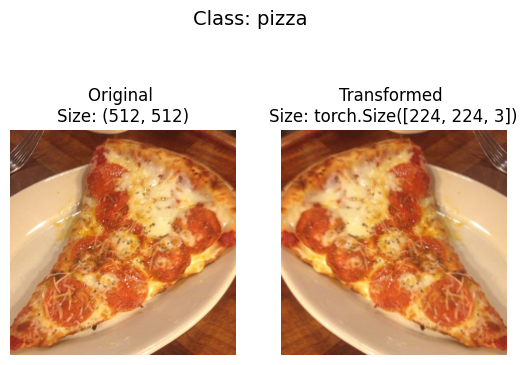

In [11]:
def plot_transformed_images(image_paths, transform, n, seed):
  """Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version."""
  # random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
      with Image.open(image_path) as f:
          fig, ax = plt.subplots(1, 2)
          ax[0].imshow(f)
          ax[0].set_title(f"Original \nSize: {f.size}")
          ax[0].axis("off")

          # Transform and plot image
          # Note: permute() will change shape of image to suit matplotlib
          # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
          transformed_image = transform(f).permute(1, 2, 0)
          ax[1].imshow(transformed_image)
          ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
          ax[1].axis("off")

          fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n = 3,
                        seed = 42)

## 4. Loading data with [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) (option 1)
We can load image classification data using [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)

In [12]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # Transforms input data into tensors
                                  target_transform = None)  # Transform labels into none

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 675
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get class names as lists
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
train_data.samples[:500:50]

[('data/pizza_steak_sushi/train/pizza/1008104.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1947572.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/271592.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/350358.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/739735.jpg', 0),
 ('data/pizza_steak_sushi/train/steak/1624747.jpg', 1),
 ('data/pizza_steak_sushi/train/steak/2287136.jpg', 1),
 ('data/pizza_steak_sushi/train/steak/2938151.jpg', 1),
 ('data/pizza_steak_sushi/train/steak/38442.jpg', 1),
 ('data/pizza_steak_sushi/train/sushi/1033302.jpg', 2)]

In [16]:
# Index on the train_data Dataset to get a single iamge and label
img, label = train_data[0][0], train_data[0][1]

img, img.dtype, label, type(label), class_names[label]

(tensor([[[0.1412, 0.1765, 0.2157,  ..., 0.2588, 0.2549, 0.2431],
          [0.1569, 0.1843, 0.2275,  ..., 0.2118, 0.2000, 0.1882],
          [0.1961, 0.2118, 0.2706,  ..., 0.1333, 0.1216, 0.1137],
          ...,
          [0.4510, 0.4471, 0.4471,  ..., 0.4471, 0.4431, 0.4275],
          [0.4314, 0.4353, 0.4431,  ..., 0.4431, 0.4314, 0.4157],
          [0.4314, 0.4353, 0.4431,  ..., 0.4314, 0.4196, 0.4000]],
 
         [[0.1529, 0.1882, 0.2314,  ..., 0.2745, 0.2706, 0.2588],
          [0.1686, 0.1961, 0.2431,  ..., 0.2275, 0.2157, 0.2039],
          [0.2078, 0.2235, 0.2824,  ..., 0.1490, 0.1333, 0.1294],
          ...,
          [0.4745, 0.4745, 0.4706,  ..., 0.5098, 0.4980, 0.4824],
          [0.4510, 0.4549, 0.4627,  ..., 0.5020, 0.4902, 0.4706],
          [0.4510, 0.4549, 0.4588,  ..., 0.4941, 0.4784, 0.4588]],
 
         [[0.0784, 0.1098, 0.1451,  ..., 0.2157, 0.2118, 0.2000],
          [0.0941, 0.1176, 0.1569,  ..., 0.1725, 0.1608, 0.1490],
          [0.1333, 0.1412, 0.1961,  ...,

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)
img.shape, img_permute.shape

(torch.Size([3, 224, 224]), torch.Size([224, 224, 3]))

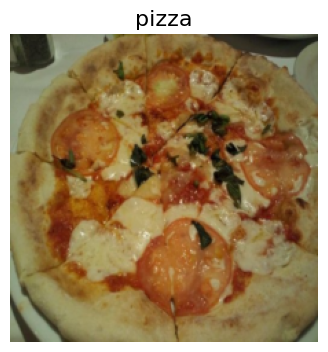

In [18]:
# Plot the image
plt.figure(figsize = (4, 4))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize = 16);

### 4.1 Turn loaded images into `Dataloaders`
A `Dataloader` is going to help us tuirn out `Dataset` into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [19]:
# Train and test dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,    # num workers are cpu cores {in colab:2 | in localMachine:maybeMore}
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(22, 8)

In [20]:
img, label = next(iter(train_dataloader))

img.shape, label.shape     # {img.shape} -> [batch_size, color_channels, height, width]

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## 5. Loading image data with a custom `Dataset`

- Want to be able to load images from file
- Want to be able to get class names from the Dataset
- Want to be able to get classe as dictionary from the Dataset


|Pros of creating a custom `Dataset`	|Cons of creating a custom `Dataset`|
|-----------------------------------|---------------------------------|
|Can create a `Dataset` out of almost anything.	|Even though you could create a `Dataset` out of almost anything, it doesn't mean it will work.|
|Not limited to PyTorch pre-built `Dataset` functions.| Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues.|

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [21]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [22]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper functions to get class_names
We want a function to:
- Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
- Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
- Turn the class names into a dict and a list and return them.

In [23]:
# Setup path for target directory
target_dir = train_dir
print(f'Target dir: {target_dir}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [24]:
def find_classes(directory : str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... Check file structure")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [25]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).
3. Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be `None`), `classes` and `class_to_idx` (from our `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or `torchvision.io` (for input/output of vision data).
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.

In [26]:
# 0. Creating a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our subclass with a targ_dir parameter and transform parameter
  def __init__(self, targ_dir : str, transform = None):
    # 3. Create several attributes for paths, transform, classes and class_to_idx
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index : int) -> Image.Image:
    """Opens an image via a path and returns it."""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    """Return total no of samples"""
    return len(self.paths)

  # 6. Overwrite __getitem()__ method to return a particular sample
  def __getitem__(self, index : int) -> Tuple[torch.Tensor, int]:
    """Returns oen sample of data, data and label(x, y)"""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necesary
    if self.transform:
      return self.transform(img), class_idx   # return data and label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [27]:
img, label = train_data[0]
img, label

(tensor([[[0.1412, 0.1765, 0.2157,  ..., 0.2588, 0.2549, 0.2431],
          [0.1569, 0.1843, 0.2275,  ..., 0.2118, 0.2000, 0.1882],
          [0.1961, 0.2118, 0.2706,  ..., 0.1333, 0.1216, 0.1137],
          ...,
          [0.4510, 0.4471, 0.4471,  ..., 0.4471, 0.4431, 0.4275],
          [0.4314, 0.4353, 0.4431,  ..., 0.4431, 0.4314, 0.4157],
          [0.4314, 0.4353, 0.4431,  ..., 0.4314, 0.4196, 0.4000]],
 
         [[0.1529, 0.1882, 0.2314,  ..., 0.2745, 0.2706, 0.2588],
          [0.1686, 0.1961, 0.2431,  ..., 0.2275, 0.2157, 0.2039],
          [0.2078, 0.2235, 0.2824,  ..., 0.1490, 0.1333, 0.1294],
          ...,
          [0.4745, 0.4745, 0.4706,  ..., 0.5098, 0.4980, 0.4824],
          [0.4510, 0.4549, 0.4627,  ..., 0.5020, 0.4902, 0.4706],
          [0.4510, 0.4549, 0.4588,  ..., 0.4941, 0.4784, 0.4588]],
 
         [[0.0784, 0.1098, 0.1451,  ..., 0.2157, 0.2118, 0.2000],
          [0.0941, 0.1176, 0.1569,  ..., 0.1725, 0.1608, 0.1490],
          [0.1333, 0.1412, 0.1961,  ...,

In [28]:
# Create a transform
train_transforms = transforms.Compose([transforms.Resize(size =(224, 224)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(size =(224, 224)),
                                      transforms.ToTensor()])

In [29]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

len(train_data_custom), len(test_data_custom)

(675, 225)

In [30]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [31]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
train_data_custom.classes == train_data.classes, test_data_custom.classes == test_data.classes

(True, True)

### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Loop through the random sample images and pplt them with matplotlib.
6. Make sure the dimensions of our images line up with matplotlib (HWC)

In [32]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # 2. Adjust display if n too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set random seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(20, 8))

  # 6. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

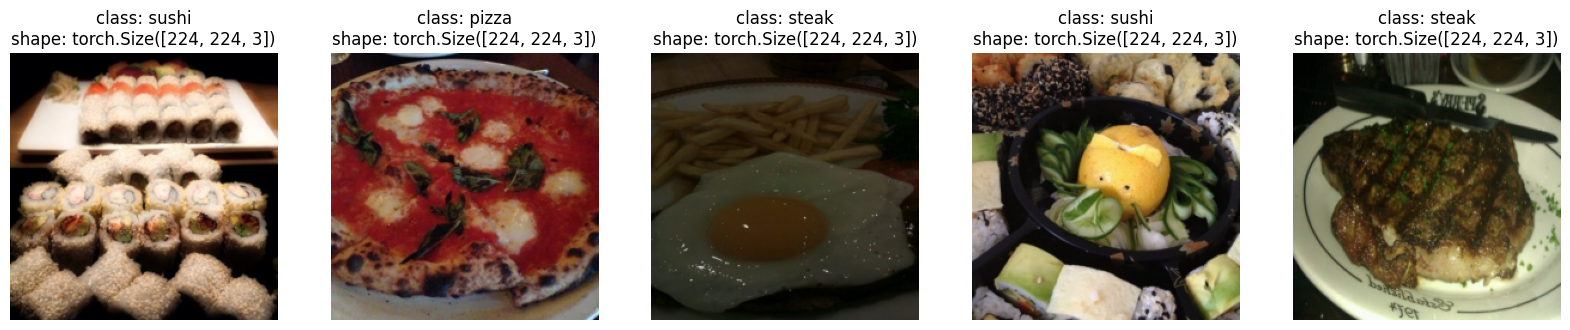

In [33]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n = 5,
                      classes = class_names,
                      seed = None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


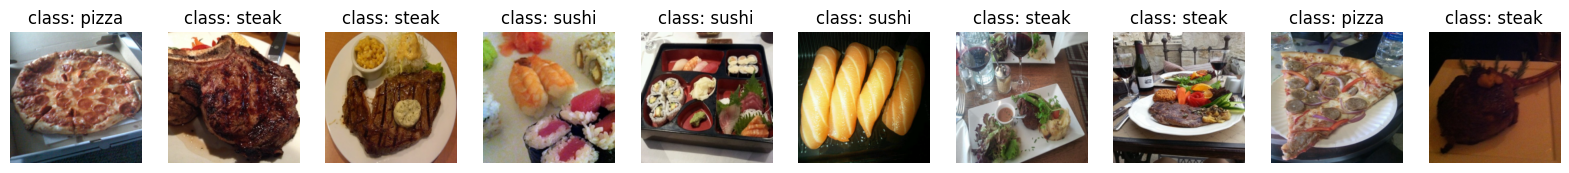

In [34]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n = 12,
                      classes = class_names,
                      seed = 42)

### 5.4 Turn custom loaded images into `Dataloaders`

In [35]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = 1,
                                     shuffle = True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    num_workers = 1,
                                    shuffle = False)

In [36]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 6. Other forms of transforms (data augmentation)
Data augmentation is the process of artificially adding diversity to the training data. In the case of image data, this may mean applying various types of image transformations to training images.

<img src = "https://jonathanbgn.com/assets/images/audio-augmentation/butterfly_augmentation.png">

<img src = "https://miro.medium.com/v2/resize:fit:1400/1*U59AuE0HklLNjGzrgz9vTQ.png">

Such techniques can result in a model that's more generalizable to unseen data.

### Check out [State-of-the-Art-Models Using Torchvision](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/) Blog
<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-trivial-augment-being-using-in-PyTorch-resize.png">

### PyTorch Official Documentation on [Illustration of transforms](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py)

In [37]:
# Trying Trivial Augment
from torchvision import transforms

train_transforms = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.TrivialAugmentWide(num_magnitude_bins=15),
        transforms.ToTensor()
])

test_transforms = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor()
])

In [38]:
# Checking image path again
print(image_path)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

data/pizza_steak_sushi


[PosixPath('data/pizza_steak_sushi/test/steak/66207.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1342025.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873655.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/13719.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3352834.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2600656.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2576310.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2307638.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1515274.jpg')]

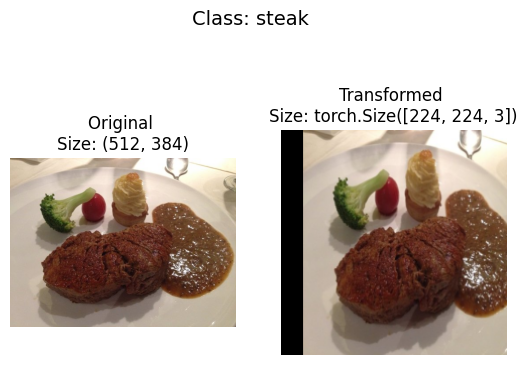

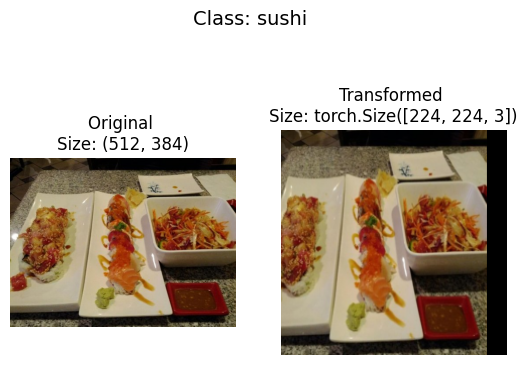

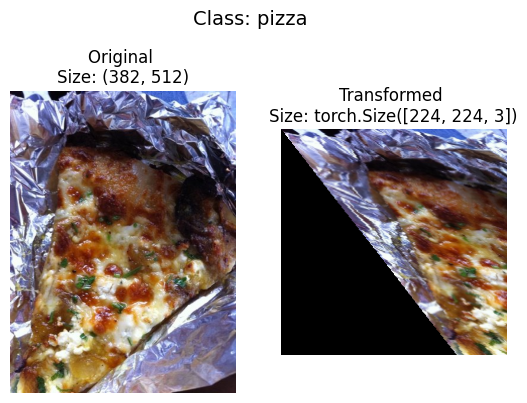

In [105]:
# Plot random transformed images
plot_transformed_images(image_paths = image_path_list,
                        transform = train_transforms,
                        n = 3,
                        seed = None)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate `TinyVGG` architecture
### [Visualizing Base Model of `TinyVGG`](https://poloclub.github.io/cnn-explainer/)

### 7.1 Creating transforms and loading data for Model 0


In [106]:
# Create a simple transform
simple_transform = transforms.Compose([transforms.Resize(size = (64, 64)),
                                       transforms.ToTensor()])

In [107]:
# Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and no of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle = False,
                                     num_workers = NUM_WORKERS)

len(train_dataloader_simple), len(test_dataloader_simple)

(22, 8)

### 7.2 Create TinyVGG Model Class

In [108]:
# Create a convolutional neural network
class TinyVGG(nn.Module):
  """Model architecture that replicates the TinyVGG model from CNN explainer website"""
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,    # selects '3x3' pixels at a time
                  stride = 1,     # skips '1' pixel at a time during selection of another 3x3 pixels
                  padding = 1,    # adds '1' pixel to edges of image
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        # Applying nn.MaxPool2d due to nn.conv2d
        # Default MaxPool2d Stride value = 2  for  kernel size = 2
        nn.MaxPool2d(kernel_size = 2)   # Lets say it takes max_val of tensor input_size(2x2)[4 tensors] & outputs a single max_val
        )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
        )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units *7*7,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    return x

In [109]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)    # labels -> pizza, sushi, and steak
                  ).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=3, bias=True)
  )
)

## 7.3 Try a forward pass on a single image (to test the model)

In [110]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [111]:
# Trying forward pass to check if TinyVGG model returns shape error or not
model_0(image_batch.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 490x3)

### Leaving the error as it is represent the `tensor shape error`

```python
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-45-0a32f1be5346> in <cell line: 2>()
      1 # Trying forward pass to check if TinyVGG model returns shape error or not
----> 2 model_0(image_batch.to(device))


<ipython-input-42-9fedc52ada84> in forward(self, x)
     46     x = self.conv_block_2(x)
     47     # print(x.shape)
---> 48     x = self.classifier(x)
     49     return x


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py in forward(self, input)
    112
    113     def forward(self, input: Tensor) -> Tensor:
--> 114         return F.linear(input, self.weight, self.bias)
    115
    116     def extra_repr(self) -> str:

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 490x3)
```
A common error during model training phase. Here, the `mat1` has shape of `32x2560` and `mat2` has shape `490x3`. Where,
- `mat1` shape is output shape of `classsifier Flattened layer` of `self.conv_block_2` and
- `mat2` is `input_features` of `nn.Linear()` from `classifier layer`

```python
(classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=3, bias=True)
  )
```

In [112]:
# Again rebuilding TinvyVGG with correct shape
# Create a convolutional neural network
class TinyVGG(nn.Module):
  """Model architecture that replicates the TinyVGG model from CNN explainer website"""
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,    # selects '3x3' pixels at a time
                  stride = 1,     # skips '1' pixel at a time during selection of another 3x3 pixels
                  padding = 1,    # adds '1' pixel to edges of image
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        # Applying nn.MaxPool2d due to nn.conv2d
        # Default MaxPool2d Stride value = 2  for  kernel size = 2
        nn.MaxPool2d(kernel_size = 2)   # Lets say it takes max_val of tensor input_size(2x2)[4 tensors] & outputs a single max_val
        )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
        )
    self.classifier = nn.Sequential(
        nn.Flatten(),       # mat1 (32 * 2560)
        nn.Linear(in_features = hidden_units *16 *16,      # mat2 (2560*3)   -> hidden units=10 so hidden units 10*16*16 = 2560
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    return x

In [113]:
torch.manual_seed(42)

model_1 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)    # labels -> pizza, sushi, and steak
                  ).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [114]:
# Trying forward pass again
model_1(image_batch.to(device))

tensor([[0.0596, 0.0616, 0.0390],
        [0.0698, 0.0646, 0.0405],
        [0.0617, 0.0633, 0.0369],
        [0.0649, 0.0627, 0.0392],
        [0.0639, 0.0597, 0.0395],
        [0.0580, 0.0591, 0.0381],
        [0.0573, 0.0582, 0.0383],
        [0.0647, 0.0630, 0.0382],
        [0.0613, 0.0619, 0.0372],
        [0.0675, 0.0629, 0.0385],
        [0.0624, 0.0619, 0.0361],
        [0.0661, 0.0639, 0.0410],
        [0.0726, 0.0693, 0.0417],
        [0.0546, 0.0573, 0.0356],
        [0.0637, 0.0615, 0.0382],
        [0.0709, 0.0686, 0.0403],
        [0.0642, 0.0601, 0.0370],
        [0.0672, 0.0643, 0.0378],
        [0.0717, 0.0629, 0.0394],
        [0.0605, 0.0635, 0.0407],
        [0.0643, 0.0573, 0.0380],
        [0.0566, 0.0617, 0.0370],
        [0.0602, 0.0623, 0.0366],
        [0.0659, 0.0626, 0.0389],
        [0.0657, 0.0651, 0.0391],
        [0.0625, 0.0613, 0.0355],
        [0.0614, 0.0590, 0.0377],
        [0.0643, 0.0596, 0.0387],
        [0.0661, 0.0647, 0.0391],
        [0.062

### 7.4 Use `torchinfo` to get an idea of the shape going thorugh out the model

In [115]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [116]:
from torchinfo import summary

# Lets check what error we get when we run summary for model_0
summary(model_0, input_size = [1, 3, 64, 64])

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 1, Conv2d: 2, ReLU: 2, Conv2d: 2, ReLU: 2, MaxPool2d: 2, Sequential: 1, Conv2d: 2, ReLU: 2, Conv2d: 2, ReLU: 2, MaxPool2d: 2, Flatten: 2]

#### The above `RuntimeError` shows the error on `Flatten` from `Classifier Layer` with same shape error

Now generating summary for `model_1`

In [117]:
from torchinfo import summary

summary(model_1, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 7.5 Create train and test loop function
- `train_step()` : takes in a model nad dataloader and trains the model on the dataloader.
- `test_step()` : takes in a model and dataloader and evaluates the model on the dataloader.

In [118]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [119]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [120]:
from tqdm.auto import tqdm

# 1. Ctreate a train funciton that takes in various model parameters + optimizer + loss_fn
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int):

  # 2. Create a empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss":[],
             "test_acc": []}

  # 3. Loop through training and testing steps for no of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model_1,
                                       dataloader = train_dataloader,
                                       optimizer = optimizer,
                                       loss_fn = loss_fn)

    test_loss, test_acc = test_step(model = model_1,
                                     dataloader = test_dataloader,
                                     loss_fn = loss_fn)
    # 4. Print out the metrics
    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} - Train acc: {(train_acc*100):.2f}% -  Test loss: {test_loss:.4f} - Test acc: {(test_acc*100):.2f}%')

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

## 7.7 Train and evaluate model_1 `TinyVGG`

In [121]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set no of epochs
EPOCHS = 10

# Recreate instance of TinyVGG
model_0 = TinyVGG(3, 10, len(class_names)).to(device)   # (input_shape, hidden_units, output_shape)

# Setup loss functions and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = EPOCHS)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0986 - Train acc: 30.30% -  Test loss: 1.1004 - Test acc: 26.17%
Epoch: 1 | Train loss: 1.0989 - Train acc: 27.56% -  Test loss: 1.1004 - Test acc: 26.17%
Epoch: 2 | Train loss: 1.0987 - Train acc: 30.30% -  Test loss: 1.1004 - Test acc: 26.17%
Epoch: 3 | Train loss: 1.0986 - Train acc: 28.93% -  Test loss: 1.1004 - Test acc: 26.17%
Epoch: 4 | Train loss: 1.0989 - Train acc: 28.93% -  Test loss: 1.1004 - Test acc: 26.17%
Epoch: 5 | Train loss: 1.0990 - Train acc: 27.56% -  Test loss: 1.1004 - Test acc: 26.17%
Epoch: 6 | Train loss: 1.0986 - Train acc: 28.93% -  Test loss: 1.1004 - Test acc: 26.17%
Epoch: 7 | Train loss: 1.0994 - Train acc: 27.56% -  Test loss: 1.1004 - Test acc: 26.17%
Epoch: 8 | Train loss: 1.0990 - Train acc: 27.56% -  Test loss: 1.1004 - Test acc: 26.17%
Epoch: 9 | Train loss: 1.0990 - Train acc: 27.56% -  Test loss: 1.1004 - Test acc: 26.17%
Total Train Time: 26.143 seconds


It looks like our model performed pretty poorly.

### What are some ways you could potentially improve it?

*Note: Check out the Section 5 : Improving a model (from a model perspective) section in [02_PyTorch_Neural_Network_Classification Notebook](https://github.com/LuluW8071/Data-Science/blob/main/Pytorch/02_PyTorch_Neural_Network_Classification/00_PyTorch_Neural_Network_Classification.ipynb) for ideas on improving `TinyVGG` model.*

Maybe lets try adding more layers of `CNN` some dropout layers as well which was done in [`03_PyTorch_Computer_Vision_Exercises`](https://github.com/LuluW8071/Data-Science/blob/main/Pytorch/03_PyTorch_Computer_Vision/03_PyTorch_Computer_Vision_Exercises.ipynb)

### 7.8 Build `ImprovedTinyVGGModel` and Train/Evaluate the Model

In [132]:
class ImprovedTinyVGGModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(ImprovedTinyVGGModel, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(hidden_units),
            nn.Dropout(0.2)  # Dropout for regularization
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(2 * hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(2 * hidden_units),
            nn.Dropout(0.2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(2 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4 * hidden_units, output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(output_shape),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 2 * hidden_units, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x

In [133]:
# Instance of Improved TinyVGG
model_1 = ImprovedTinyVGGModel(3, 32, len(class_names)).to(device)   # (input_shape, hidden_units, output_shape)

model_1

ImprovedTinyVGGModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
 

In [134]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set no of epochs
EPOCHS = 10

# Setup loss functions and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model = model_1,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = EPOCHS)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0985 - Train acc: 39.68% -  Test loss: 1.2439 - Test acc: 27.34%
Epoch: 1 | Train loss: 0.9602 - Train acc: 54.36% -  Test loss: 1.1795 - Test acc: 36.72%
Epoch: 2 | Train loss: 0.8830 - Train acc: 59.94% -  Test loss: 0.9387 - Test acc: 53.52%
Epoch: 3 | Train loss: 0.8467 - Train acc: 63.97% -  Test loss: 0.9275 - Test acc: 57.42%
Epoch: 4 | Train loss: 0.8080 - Train acc: 63.92% -  Test loss: 0.9569 - Test acc: 55.08%
Epoch: 5 | Train loss: 0.7754 - Train acc: 66.67% -  Test loss: 0.9156 - Test acc: 57.03%
Epoch: 6 | Train loss: 0.7460 - Train acc: 72.44% -  Test loss: 0.8534 - Test acc: 66.02%
Epoch: 7 | Train loss: 0.7750 - Train acc: 66.38% -  Test loss: 0.8423 - Test acc: 57.42%
Epoch: 8 | Train loss: 0.6806 - Train acc: 70.93% -  Test loss: 0.7949 - Test acc: 56.64%
Epoch: 9 | Train loss: 0.7136 - Train acc: 71.83% -  Test loss: 0.8616 - Test acc: 59.38%
Total Train Time: 26.653 seconds


Even though we added more `CNN` layers with `dropout regularization` and `Batchnormalization` we still haven't got good results.

So now lets checkout the loss curves for `TinyVGGModel` and `ImprovedTinyVGGModel`

### 7.9 Plot the loss curves

A **loss curve** is a way of tracking you model's progress over time.

### [Click here to know about Loss Curves](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)


In [135]:
# Get the model_0 and model_1 key results
model_0_results.keys(), model_1_results.keys()

(dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc']),
 dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc']))

In [145]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """ Plots training curves of a results dictionary """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

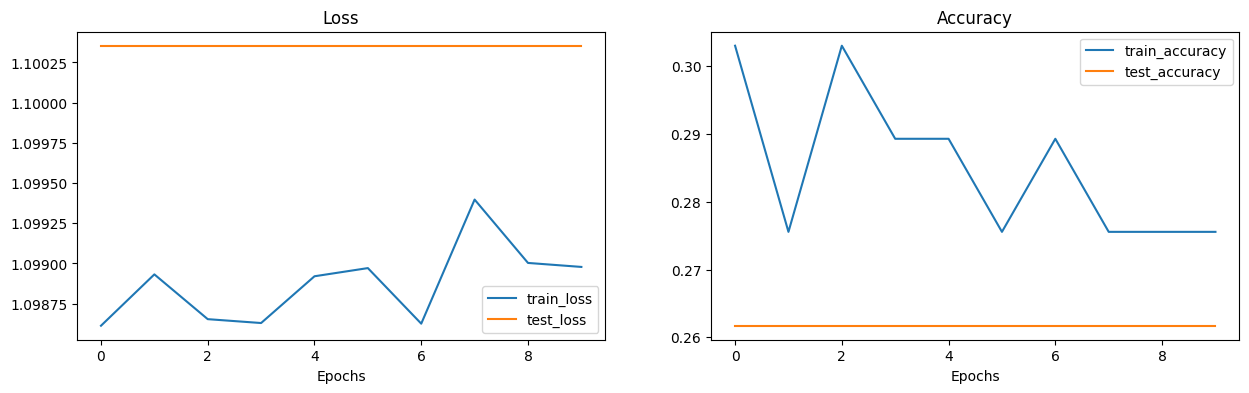

In [146]:
plot_loss_curves(model_0_results)

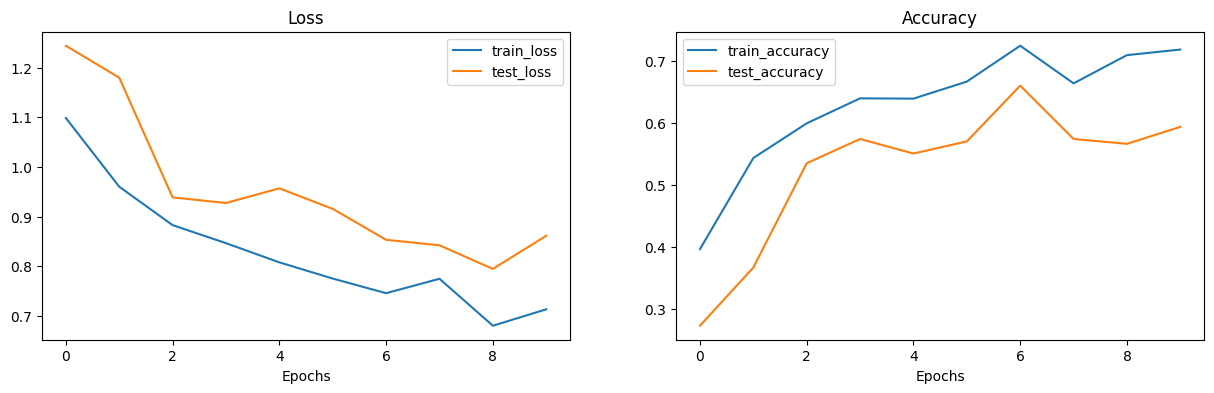

In [147]:
plot_loss_curves(model_1_results)

## 8. Exploring loss curves

Looking at training and test loss curves is a great way to see if your model is **overfitting**. An **overfitting** model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is **overfitting**. As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other which is also called **best fit model**.

<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg">

*Left: If your training and test loss curves aren't as low as you'd like, this is considered underfitting.*
*Middle: When your test/validation loss is higher than your training loss this is considered overfitting.*
*Right: The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do.

### For more on these, see [Google's Interpreting Loss Curves](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic) guide.